## 1. Load data from all sessions

#### Load name and path of all sessions

In [2]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from session_utils import find_all_sessions

# Find all included sessions from Google sheet, with structure session_name: path
session_dict = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')
print(f'{len(session_dict.items())} sessions found')

57 sessions found


## 2. Loop over all sessions, load data and filter for pyramidal cells
### Criteria:
#### - A. Cluster marked 'good' in phy
#### - B. Cluster depth 0 +-200um
#### - C. Mean FR < 10 Hz
#### - D. Mean spike width >500us
#### - E. Burst index - first moment of AC < 25

In [3]:
from ephys import *
import matplotlib.pyplot as plt


total_cells_inc = 0
total_cells_processed = 0

cluster_info_all = pd.DataFrame()

for session, session_path in session_dict.items():
    
    # Create ephys object
    obj = ephys(recording_type = 'nexus', path = session_path)
    
    ## A. Load good cells from phy
    obj.load_spikes('good')
    
    # Get cluster info from phy
    cluster_info = obj.spike_data['cluster_info']

    cluster_info['session'] = session
    
    # Get total good cells for session
    total_cells = len(cluster_info.index)
    total_cells_processed += total_cells
    
    
    ## B. Get cluster depths and exclude any outside of 0 +-200um
    cluster_info = cluster_info[cluster_info['depth'].between(-200, 200)].copy()
    

    ## C. Filter for mean firing rate between 0-10 Hz
    cluster_info = cluster_info[cluster_info['fr'].between(0, 10)]
    
    ## D. Filter for spike width >300 us from template
    if not cluster_info.empty:
        obj.load_mean_waveforms(clusters_to_load = list(cluster_info.index)) #Pick up to 500 spikes at random for performance

        # Calculate spike width for each cluster from mean of every 50th spike 
        for cluster, mean_waveform in obj.mean_waveforms.items():
            
            # Find peak to trough time in us
            peak = np.argmin(mean_waveform)
            trough = np.argmax(mean_waveform[peak:]) + peak
            peak_to_trough = trough - peak         

            # # Plot for sanity
            # print(f'Spike width for cluster {cluster}: {peak_to_trough / obj.spike_data["sampling_rate"] * 1e6} us')
            # plt.plot(mean_waveform)
            # plt.scatter(trough, mean_waveform[trough])
            # plt.scatter(peak, mean_waveform[peak])
            # plt.show()

            cluster_info.loc[cluster, 'spike_width_microseconds'] = (peak_to_trough / obj.spike_data['sampling_rate']) * 1e6
        
        # Filter for spike width > 300us as in Wills et al., 2010
        cluster_info = cluster_info[cluster_info['spike_width_microseconds'] > 500].copy()

    
    ## E. Calculate burst index and filter
    if not cluster_info.empty:
        
        # Reload spike data only for included cells
        clusters_inc = list(cluster_info.index)
        obj.load_spikes(clusters_to_load = clusters_inc)
        
        # Generate autocorrelograms and burst index for each cluster
        from burst_index_and_autocorrelograms import *

        spike_times_inc = obj.spike_data['spike_times']
        spike_clusters_inc = obj.spike_data['spike_clusters']

        autocorrelograms, first_moments = compute_autocorrelograms_and_first_moment(spike_times_inc, 
                                                                                     spike_clusters_inc, 
                                                                                     bin_size = 0.001, #1ms
                                                                                     time_window = 0.05) #50ms
        
        cluster_info['first_moment_AC'] = first_moments.values()
        
        # Filter for first moment <25
        cluster_info = cluster_info[cluster_info['first_moment_AC'] < 25]
            
    ## SAVE INCLUDED CLUSTER IDs TO .NPY
    clusters_inc = cluster_info.index
    n_clusters_inc = len(cluster_info.index)
    total_cells_inc += n_clusters_inc

    # Append session to cluster_info_all index
    cluster_info.index = cluster_info['session'] + '_' + cluster_info.index.astype(str)
    
    # Concat cluster info for all sessions
    cluster_info_all = pd.concat([cluster_info_all, cluster_info])

    np.save(f'{session_path}/clusters_inc.npy', clusters_inc)        
        
    print(f'Session {session}: {n_clusters_inc} cells retained of {total_cells} good cells from phy. Retained cells: {clusters_inc.values}')

print(f'Total cells retained: {total_cells_inc} of total {total_cells_processed} good cells from phy')

Spike width for cluster 324: 270.8333333333333 us
Session 230503_r1354: 0 cells retained of 5 good cells from phy. Retained cells: []
Spike width for cluster 229: 395.8333333333333 us
Spike width for cluster 245: 354.1666666666667 us
Spike width for cluster 248: 375.0 us
Session 230504_r1354: 0 cells retained of 8 good cells from phy. Retained cells: []
Session 230505_r1354: 0 cells retained of 4 good cells from phy. Retained cells: []
Spike width for cluster 226: 291.6666666666667 us
Spike width for cluster 233: 291.6666666666667 us
Spike width for cluster 236: 354.1666666666667 us
Spike width for cluster 242: 312.5 us
Spike width for cluster 247: 583.3333333333334 us
Spike width for cluster 251: 708.3333333333334 us
Spike width for cluster 256: 687.5 us
Spike width for cluster 260: 645.8333333333334 us
Spike width for cluster 264: 479.16666666666663 us
Spike width for cluster 269: 333.3333333333333 us
Spike width for cluster 274: 562.5 us
Spike width for cluster 281: 812.5 us
Spike w

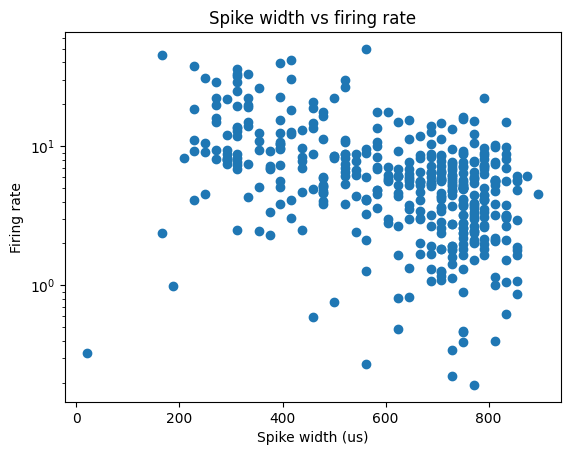

In [72]:
plt.scatter(cluster_info_all['spike_width_microseconds'], cluster_info_all['fr'])
plt.xlabel('Spike width (us)')
# Set y axis to log 10 scale
plt.yscale('log')
plt.ylabel('Firing rate')
plt.title('Spike width vs firing rate')
plt.show()

In [62]:
# Load spatial info all
spatial_info_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Select only rows including 'open-field_1'
spatial_info_open_field_1 = spatial_info_all[spatial_info_all.index.str.contains('raw_open-field_1')]

# Drop 'open-field_1' from index
spatial_info_open_field_1.index = spatial_info_open_field_1.index.str.replace('raw_open-field_1_', '')


spatial_info_open_field_1

,bits_per_spike,bits_per_sec,age
230504_r1354_248,0.140865,0.311954,24
230506_r1354_191,0.012147,0.371689,26
230506_r1354_203,0.012131,0.125972,26
230506_r1354_214,0.01688,0.16295,26
230506_r1354_236,0.014669,0.128275,26
...,...,...,...
231101_r1428_283,0.021809,0.206171,34
231101_r1428_285,0.053854,0.352384,34
231101_r1428_301,0.070981,0.308645,34
231101_r1428_309,0.028625,0.092814,34


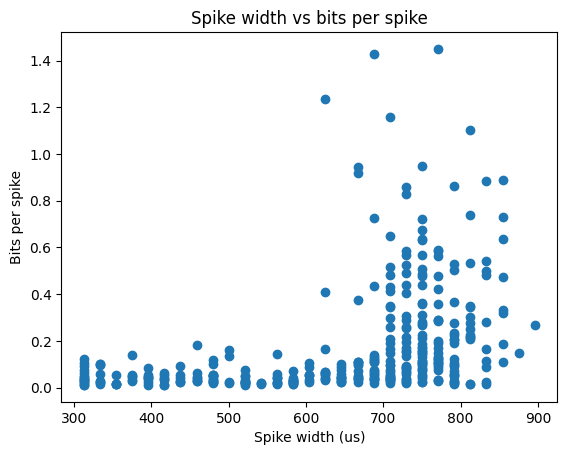

In [70]:
# Merge cluster_info_all with spatial_info_open_field_1
cluster_info_spatial_info = pd.merge(cluster_info_all, spatial_info_open_field_1, left_index = True, right_index = True)

# Plot spike width against bits per spike
plt.scatter(cluster_info_spatial_info['spike_width_microseconds'], cluster_info_spatial_info['bits_per_spike'])
plt.xlabel('Spike width (us)')
plt.ylabel('Bits per spike')
plt.title('Spike width vs bits per spike')
plt.show()

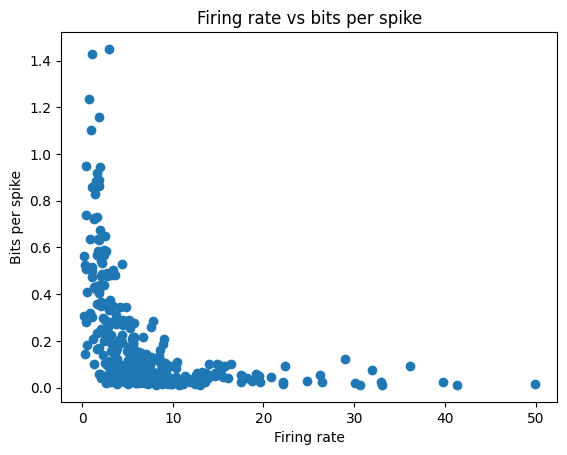

In [73]:
# Plot firing rate against bits per spike
plt.scatter(cluster_info_spatial_info['fr'], cluster_info_spatial_info['bits_per_spike'])
plt.xlabel('Firing rate')
plt.ylabel('Bits per spike')
plt.title('Firing rate vs bits per spike')
plt.show()

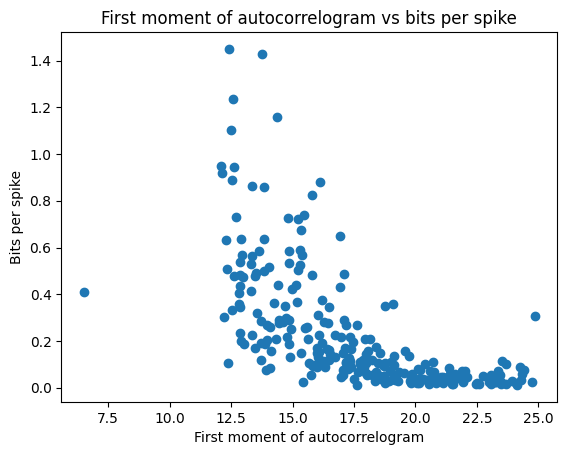

In [65]:
# Plot first moment of autocorrelogram against bits per spike
plt.scatter(cluster_info_spatial_info['first_moment_AC'], cluster_info_spatial_info['bits_per_spike'])
plt.xlabel('First moment of autocorrelogram')
plt.ylabel('Bits per spike')
plt.title('First moment of autocorrelogram vs bits per spike')
plt.show()

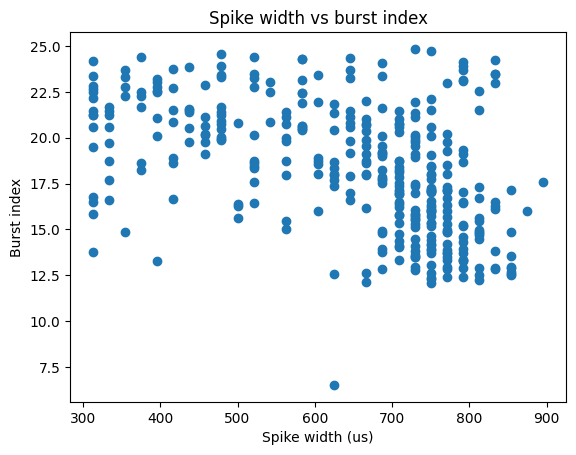

In [74]:
# Plot spike width vs burst index
plt.scatter(cluster_info_spatial_info['spike_width_microseconds'], cluster_info_spatial_info['first_moment_AC'])
plt.xlabel('Spike width (us)')
plt.ylabel('Burst index')
plt.title('Spike width vs burst index')
plt.show()

In [2]:
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.curation as sc
import numpy as np

from spikeinterface.postprocessing import compute_template_metrics, compute_spike_amplitudes

recording_path = '/home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-06/230506_r1354_raw_open-field_1_preprocessed'

recording = si.load_extractor(recording_path)
recording

sorting = se.read_phy('/home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-06/230506_sorting_ks2_custom', exclude_cluster_groups=['noise', 'mua'])
sorting

sorting = sc.remove_excess_spikes(sorting, recording)

clusters_inc = np.load('/home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-06/clusters_inc.npy')


waveform_extractor = si.extract_waveforms(recording=recording, 
                                          sorting=sorting, 
                                          folder = f'waveforms',
                                          load_if_exists=True,
                                          n_jobs = -1)


template_metrics = compute_template_metrics(waveform_extractor)
amplitudes = compute_spike_amplitudes(waveform_extractor, outputs = 'by_unit')
display(template_metrics.loc[clusters_inc, :])

/home/isabella/anaconda3/envs/env_38/lib/python3.8/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.95.0 is recommended
  warnings.warn(
/home/isabella/anaconda3/envs/env_38/lib/python3.8/site-packages/spikeinterface/core/binaryrecordingextractor.py:77: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")
/tmp/ipykernel_6085/2018399968.py:21: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  waveform_extractor = si.extract_waveforms(recording=recording,
/home/isabella/anaconda3/envs/env_38/lib/python3.8/site-packages/spikeinterface/core/binaryrecordingextractor.py:77: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be d

extract amplitudes:   0%|          | 0/901 [00:00<?, ?it/s]

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks
247,0.000702,-0.371268,0.000277,138417.465261,-23518.559465,2,1
251,0.000735,-0.380923,0.000308,110297.486297,-24685.252501,2,1
256,0.000713,-0.293197,0.000275,179446.614515,-25267.001117,2,1
260,0.000556,-0.332304,0.00026,172230.387833,-19050.836256,2,1
274,0.000585,-0.440385,0.00029,124429.51421,-28026.711799,2,1
281,0.000925,-0.22442,0.000254,155199.72169,-25973.244256,2,1
292,0.000854,-0.288905,0.000287,170059.612439,-33917.07426,2,1
300,0.000775,-0.316017,0.000269,143909.395068,-29789.268604,2,1
308,0.000758,-0.310607,0.000262,212268.374293,-45090.832987,2,1
322,0.000817,-0.230779,0.000183,261396.721077,-44850.85546,2,1


In [8]:
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import ipywidgets as widgets

recording_highpass = spre.highpass_filter(recording, freq_min=300)

channel_dict = si.get_template_extremum_channel(waveform_extractor)
good_units = {key: channel_dict[key] for key in channel_dict if key in clusters_inc}

channels = list(good_units.values())
unit_ids = list(good_units.keys())

unit_index = 1

def plot_data(start, time_window):
    fig, ax = plt.subplots()
    sw.plot_traces(recording_highpass, time_range=(start, start + time_window), channel_ids=[channels[unit_index]], show_channel_ids=True, ax=ax, color = 'blue')
    sw.plot_rasters(sorting=sorting, segment_index=0, time_range=(start, start + time_window), unit_ids=[unit_ids[unit_index]], color='orange', ax=ax)
    plt.show()

# Define the time range for the widget
total_time = recording_highpass.get_num_frames() / recording_highpass.get_sampling_frequency()
time_window = 1  # Length of the time window in seconds

# Create the widget
widgets.interact(plot_data,
                 start=widgets.FloatSlider(min=0, max=total_time-time_window, step=0.008, value=0, description='Start Time'),
                 time_window=widgets.FloatSlider(min=0.001, max=time_window, step=0.0005, value=time_window, description='Time Window'))


interactive(children=(FloatSlider(value=0.0, description='Start Time', max=899.00625, step=0.008), FloatSlider…

<function __main__.plot_data(start, time_window)>